# AIB Datahack

So, during my year back in college, studying for an M.Sc in Business Analytics at UCD Smurfit, myself and my good buddy @Pete decided to take on the AIB Datahack which was held in, I think, November 2016. The Datahack was hosted by AIB in their head office in Dublin, and consisted of a full days work (8 hours) tackling a machine learning problem. 

The problem we were presented with that morning was a supervised learning problem. Using what we know, could we find a good algorithm to learn and accurately predict energy ratings for houses in Ireland. We went into the competition confident that we knew what we were doing, but quickly realised we'd a lot to learn. All, in all, it was a worthwhile experience and focused us both on what we needed to learn over the coming months.

Now that I've completed my course and have returned to work, I'm going to try and tackle the problem again, and see if I can do a little better this time around.

First off, using this very useful Kernal I found on Kaggle (https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) I'm going to do a full data exploration of the data we were given for the competition. Once that is complete, I'll dive into some real machine learning.

So without further adieu...lets get stuck in!

## Itinerary 

What I hope to tackle in this notebook is as follows:
1. **Understand the problem.** Look at each variable and do a philosophical analysis about their meaning and importance for this problem.

2. **Univariable study.** Focus on the dependent variable and try to know a little bit more about it.

3. **Multivariate study.** Try to understand how the dependent variable and independent variables relate.

4. **Basic cleaning.** Clean the dataset and handle the missing data, outliers and categorical variables.

5. **Test assumptions.** Check if our data meets the assumptions required by most multivariate techniques.

In [95]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

So the training data set is pretty big. I'm going to read it all into memory for now but further down the line I plan on looking at better ways of doing this.

In [96]:
# Data Import
df = pd.read_csv("data/training_small.txt", sep='\t', encoding='ISO-8859-1', header=0, low_memory=False, index_col=0)

df.head(3)

,County,Type,Year,RatingType,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,...,EffSecondHeatGenPlant,PercSecondHeat,FuelTypeThirdBoiler,EffThirdHeatGenPlant,PercThirdHeat,HeatingSystemSolarSpace,TotPrimaryEnergyFac,TotCO2Emissions,PrimaryEnergySecondarySpace,EnergyMainWater
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,Co. Wexford,Mid-terrace house,Y1890.0,Existing,F,418.42,52.04 sq. m,2.10,2.30,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,2335.6809
523113,Co. Clare,Detached house,Y1901.0,Existing,G,520.35,147.44 sq. m,2.01,0.75,0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7144.838,4470.0759
271393,Co. Kerry,Detached house,Y1968.0,Existing,D2,281.33,104.84 sq. m,0.38,0.13,0.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2127.347,5837.4729


In [97]:
# Lets check the columns
df.columns

Index(['County', 'Type', 'Year', 'RatingType', 'EnergyRatingCat',
       'EnergyRatingCont', 'GroundFloorArea', 'AvgWallU', 'AvgRoofU',
       'AvgFloorU',
       ...
       'EffSecondHeatGenPlant', 'PercSecondHeat', 'FuelTypeThirdBoiler',
       'EffThirdHeatGenPlant', 'PercThirdHeat', 'HeatingSystemSolarSpace',
       'TotPrimaryEnergyFac', 'TotCO2Emissions', 'PrimaryEnergySecondarySpace',
       'EnergyMainWater'],
      dtype='object', length=140)

141 columns, thats a lot of information to work with. Two of these however are the target variables so I'm going to split these out into their own seperate dataframe.

In [98]:
target_cols = ['EnergyRatingCat', 'EnergyRatingCont']

target = df.loc[:,target_cols]
training = df.copy()
# training = df.drop(target_cols, axis='columns')

## Variable Exploration

In order to have some discipline in our analysis, we can create an Excel spreadsheet with the following columns:

* Variable - Variable name.
* Type - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.
* Segment - Identification of the variables' segment. We can define three possible segments: building, space or location. When we say 'building', we mean a variable that relates to the physical characteristics of the building (e.g. 'OverallQual'). When we say 'space', we mean a variable that reports space properties of the house (e.g. 'TotalBsmtSF'). Finally, when we say a 'location', we mean a variable that gives information about the place where the house is located (e.g. 'Neighborhood').
* Expectation - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible values.
* Conclusion - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'.
* Comments - Any general comments that occured to us.


This processes ended up being a very useful exercise, and made me properly think about each variable in the dataset. The variables I believe are most important, to begin with are as follows:
* Year
* AvgWallU, AvgRoofU, AvgFloorU, AvgWindowU, AvgDoorU
* ExposedWallArea, ExposedRoofArea
* TotFloorArea, TotWindowArea, TotDoorArea
* MainSHFuel, MainWHFuel, WallStructure

I'll begin with these and explore the other variables later.

## Data Exploration
With the above task complete, lets do the interesting stuff....exploring the data!

We have two columns in our target variable dataframe: EnergyRatingCat and EnergyRatingCont. 

1. **EnergyRatingCat** is the categorical energy rating given to the property (A, B1, C2, etc.)
2. **EnergyRatingCont** on the otherhand is an numerical rating given to the property.

In [99]:
# EnergyRatingCat
target.loc[:, 'EnergyRatingCat'].describe()

count     4999
unique      15
top         D1
freq       672
Name: EnergyRatingCat, dtype: object

In [100]:
# Is there any null values in this column?
target.loc[:, 'EnergyRatingCat'].isnull().sum()

0

Null values aren't very useful to use, so lets from them.

In [101]:
target = target.drop(target.loc[target['EnergyRatingCat'].isnull()].index)

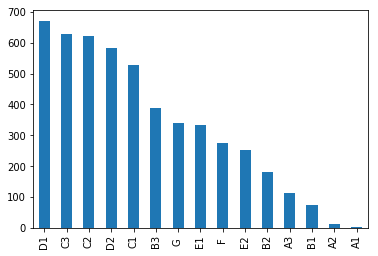

In [102]:
target.loc[:, 'EnergyRatingCat'].value_counts().plot(kind='bar')

Very quickly we see a unbalance in the data towards poorly rated houses, with D1, C2 and C3 appearing most frequently in the data set. Conversely, A1 and A2 are by far the least prevalent.

In [103]:
# EnergyRatingCont
target.loc[:, 'EnergyRatingCont'].describe()

count    4999.000000
mean      258.078954
std       150.870140
min        18.940000
25%       173.325000
50%       223.810000
75%       297.410000
max      2016.710000
Name: EnergyRatingCont, dtype: float64

In [104]:
# Is there any null values in this column?
target.loc[:, 'EnergyRatingCont'].isnull().sum()

0

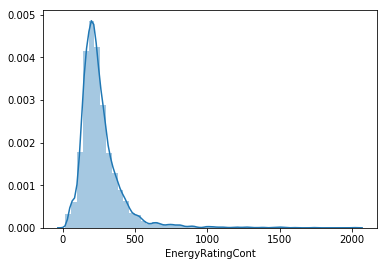

In [105]:
sns.distplot(target['EnergyRatingCont']);

Hmmm...this doesn't look right. Surely there is some sort of outlier skewing this. Lets look at values above 1,000.

In [106]:
outliers = target[target.loc[:, 'EnergyRatingCont']>1000]
outliers.head(10)

,EnergyRatingCat,EnergyRatingCont
BuildingID,,
212192,G,1459.77
644207,G,1284.08
283437,G,1525.85
133323,G,1079.74
513850,G,1200.34
459394,G,1257.39
257884,G,1333.83
92754,G,1273.37
19836,G,2016.71


Ok so we can clearly see that the higher on the scale you go, the worse the energy rating your house will get. Out of curiosity, lets look at the distribution without houses rated above 1000.

In [107]:
target_1000 = target[target.EnergyRatingCont < 1000]
target_1000.head()

,EnergyRatingCat,EnergyRatingCont
BuildingID,,
190835,F,418.42
523113,G,520.35
271393,D2,281.33
585961,C2,188.17
624083,B3,134.95


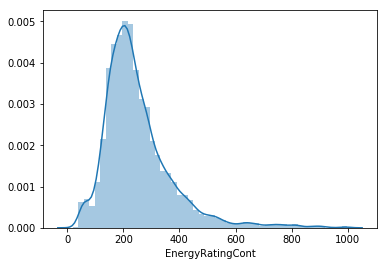

In [108]:
sns.distplot(target_1000['EnergyRatingCont']);

Observations:
1. Deviates from the normal distribution.
2. Has appreciable positive skewness.
3. Shows peakedness.

In [109]:
#skewness and kurtosis
print("Skewness: %f" % target['EnergyRatingCont'].skew())
print("Kurtosis: %f" % target['EnergyRatingCont'].kurt())

Skewness: 3.371016
Kurtosis: 19.980926


In [110]:
#skewness and kurtosis
print("Skewness: %f" % target_1000['EnergyRatingCont'].skew())
print("Kurtosis: %f" % target_1000['EnergyRatingCont'].kurt())

Skewness: 1.865784
Kurtosis: 5.521997


### Relationship with numerical variables

In [111]:
important_numerical_cols = ['Year', 'GroundFloorArea', 'AvgWallU', 'AvgRoofU', 'AvgFloorU', 
                  'AvgWindowU', 'AvgDoorU', 'ExposedWallArea', 'ExposedRoofArea', 
                  'TotFloorArea', 'TotWindowArea', 'TotDoorArea', 'EnergyRatingCont']

important_categorical_cols = ['MainSHFuel', 'MainWHFuel', 'WallStructure', 'EnergyRatingCat', 'EnergyRatingCont']

training_num = training.loc[:,important_numerical_cols]
training_cat = training.loc[:,important_categorical_cols]
training_cat.head(3)

,MainSHFuel,MainWHFuel,WallStructure,EnergyRatingCat,EnergyRatingCont
BuildingID,,,,,
190835,Heating Oil,Heating Oil,Masonry,F,418.42
523113,Heating Oil,Heating Oil,Masonry,G,520.35
271393,Heating Oil,Heating Oil,Masonry,D2,281.33


So that all these variables can be properly explored, a little but of processing has to be done to ensure they are all numerical only.

In [112]:
training_num.loc[:, 'Year'].isnull().sum()

0

In [113]:
# First, lets remove the Y from infront of every year
training_num['pYear'] = training_num['Year'].map(lambda x: x[1:])
training_num['pGroundFloorArea'] = training_num['GroundFloorArea'].map(lambda x: float(x[:-5]))

In [114]:
training_num.head(3)

,Year,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,AvgWindowU,AvgDoorU,ExposedWallArea,ExposedRoofArea,TotFloorArea,TotWindowArea,TotDoorArea,EnergyRatingCont,pYear,pGroundFloorArea
BuildingID,,,,,,,,,,,,,,,
190835,Y1890.0,52.04 sq. m,2.10,2.30,0.61,2.71,3.00,32.78,73.08,33.69,7.08,2.05,418.42,1890.0,52.04
523113,Y1901.0,147.44 sq. m,2.01,0.75,0.94,2.63,3.96,211.22,93.40,96.77,37.00,5.95,520.35,1901.0,147.44
271393,Y1968.0,104.84 sq. m,0.38,0.13,0.68,2.81,0.00,94.41,104.84,104.84,17.90,0.00,281.33,1968.0,104.84


In [115]:
training_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 190835 to 486977
Data columns (total 15 columns):
Year                4999 non-null object
GroundFloorArea     4999 non-null object
AvgWallU            4513 non-null float64
AvgRoofU            4999 non-null float64
AvgFloorU           4999 non-null float64
AvgWindowU          4999 non-null float64
AvgDoorU            4999 non-null float64
ExposedWallArea     4999 non-null float64
ExposedRoofArea     4999 non-null float64
TotFloorArea        4999 non-null float64
TotWindowArea       4999 non-null float64
TotDoorArea         4999 non-null float64
EnergyRatingCont    4999 non-null float64
pYear               4999 non-null object
pGroundFloorArea    4497 non-null float64
dtypes: float64(12), object(3)
memory usage: 624.9+ KB


### Quick observation
Straight away I can see the number of values for GroundFloorArea has reduced from 4999 to 4497 and I'm not sure why. Lets quickly look at these null values to see whats happened.

In [116]:
training_num[training_num['pGroundFloorArea'].isnull()].head()

,Year,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,AvgWindowU,AvgDoorU,ExposedWallArea,ExposedRoofArea,TotFloorArea,TotWindowArea,TotDoorArea,EnergyRatingCont,pYear,pGroundFloorArea
BuildingID,,,,,,,,,,,,,,,
659767,Y1954.0,nan sq. m,1.25,0.37,0.70,4.63,3.0,126.57,77.99,58.63,15.51,1.85,283.37,1954.0,NaN
361024,Y1998.0,nan sq. m,0.21,0.23,0.41,1.51,3.0,200.41,154.70,130.00,40.45,3.70,111.43,1998.0,NaN
191876,Y1932.0,nan sq. m,0.88,0.54,0.73,3.07,0.0,127.69,64.94,65.04,16.34,0.00,215.73,1932.0,NaN
471221,Y1980.0,nan sq. m,NaN,0.13,0.57,2.70,0.0,66.52,40.02,40.02,14.67,0.00,185.12,1980.0,NaN
146053,Y2002.0,nan sq. m,0.30,0.13,0.41,2.70,3.0,85.20,47.57,47.57,13.52,2.62,214.19,2002.0,NaN


Ah ok, we can see that the original GroundFloorArea variable had 'nan' values in but we still being counted as they were strings. Glad we found this!

In [117]:
# So that the pYear 
null_pYear = training_num[training_num['pYear']=='nan']
null_pYear.index

Int64Index([], dtype='int64', name='BuildingID')

### Scatter Plots - Numerical Variables

The next task is to plot some of these independent variables with the dependent variable and see if we can spot some trends/relationships that may be useful to us.

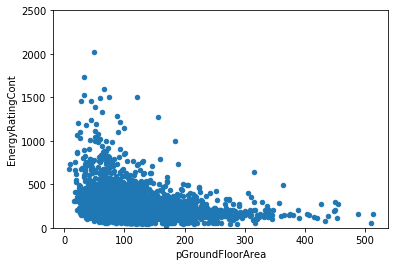

In [118]:
var = 'pGroundFloorArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

Straight away we can see a trend that areas with larger ground floor areas generally have better energy ratings.

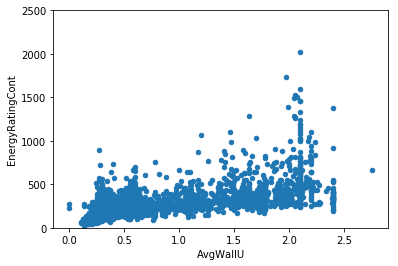

In [119]:
var = 'AvgWallU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

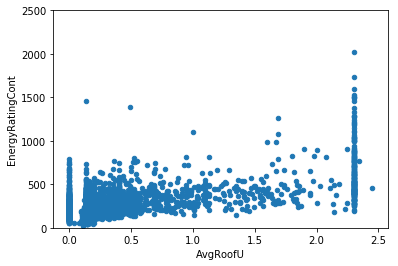

In [120]:
var = 'AvgRoofU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

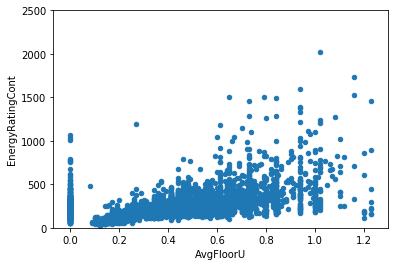

In [121]:
var = 'AvgFloorU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

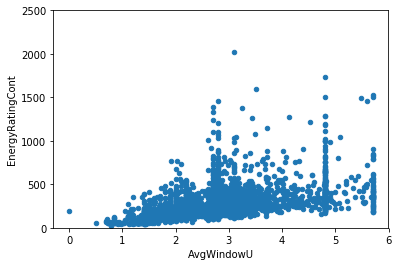

In [122]:
var = 'AvgWindowU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

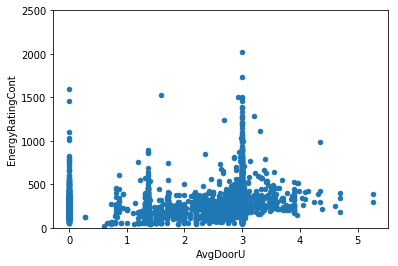

In [123]:
var = 'AvgDoorU'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

For all U values, there seems to be a weak positive linear relationship with the dependent variable.

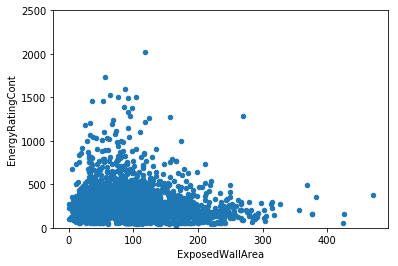

In [124]:
var = 'ExposedWallArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

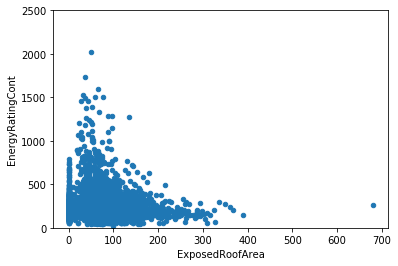

In [125]:
var = 'ExposedRoofArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

Similar to GroundFloorArea above, there looks like theres a trend where the higher the Exposed Roof or Wall area, the better energy rating the house has.

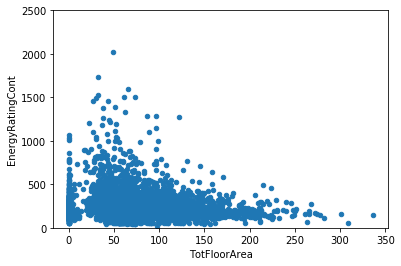

In [126]:
var = 'TotFloorArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

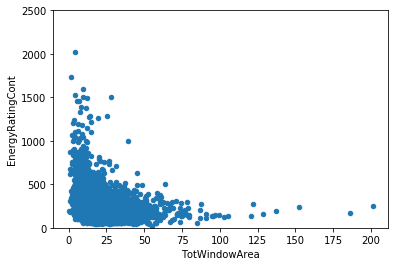

In [127]:
var = 'TotWindowArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

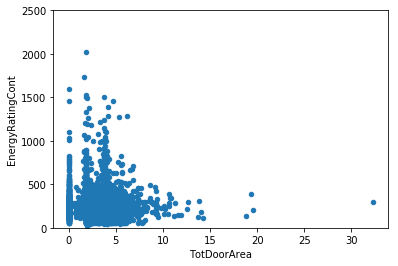

In [128]:
var = 'TotDoorArea'
training_num.plot.scatter(x=var, y='EnergyRatingCont', ylim=(0,2500));

### Take aways
One thing I've noticed from the plots above, is a lot of the independent variables have a lot of 0 values. Now when we talk about Total Areas and U values, 0 is not a valid answer. It's virtually impossible to have zero heat transfer through a wall and it's definitely impossible for a property to have no doors. Lets take a quick look at the volume of zero values each variable has.

In [129]:
training_num[training_num == 0].head()

,Year,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,AvgWindowU,AvgDoorU,ExposedWallArea,ExposedRoofArea,TotFloorArea,TotWindowArea,TotDoorArea,EnergyRatingCont,pYear,pGroundFloorArea
BuildingID,,,,,,,,,,,,,,,
190835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271393,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
585961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
zero_count = training_num.astype(bool).sum(axis=0).reset_index()
zero_count.columns = ['variable', 'sum']
zero_count['sum'] = zero_count['sum'].apply(lambda x: (x-4999)*-1)
zero_count['percentage'] = zero_count['sum'].apply(lambda x: (x/4999)*100)
zero_count

,variable,sum,percentage
0,Year,0,0.000000
1,GroundFloorArea,0,0.000000
2,AvgWallU,2,0.040008
3,AvgRoofU,517,10.342068
4,AvgFloorU,565,11.302260
5,AvgWindowU,1,0.020004
6,AvgDoorU,565,11.302260
7,ExposedWallArea,2,0.040008
8,ExposedRoofArea,518,10.362072
9,TotFloorArea,565,11.302260


As we can see from the above summary, AvgRoofU, AvgFloorU, AvgDoorU, ExposedRoofArea, TotFloorArea and TotDoorArea all are showing over 10% of their values as zero, which doesn't make much sense. To this effect, we should treat them as null values and replace them, possibly with the variable mean, before using it in our model.

### Scatter Plots - Numerical Variables

In [131]:
# I want the plot to be nicely ordered, so lets define that order
correct_sort = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F ', 'G ']

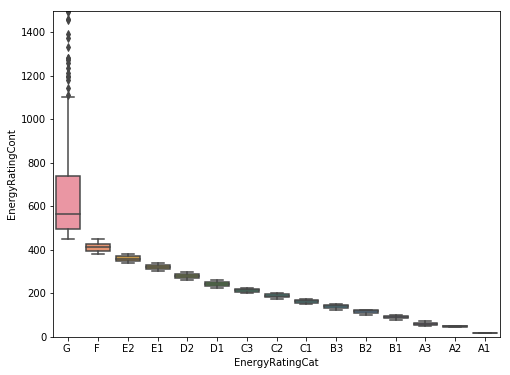

In [132]:
var = 'EnergyRatingCat'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat, order=correct_sort[::-1])
fig.axis(ymin=0, ymax=1500);

In [133]:
# Again, I want the order to be useful, lets order by the variable mean
correct_sort = training_cat.groupby(['MainSHFuel']).mean().to_dict()['EnergyRatingCont']
correct_sort = sorted(correct_sort, key=correct_sort.get)

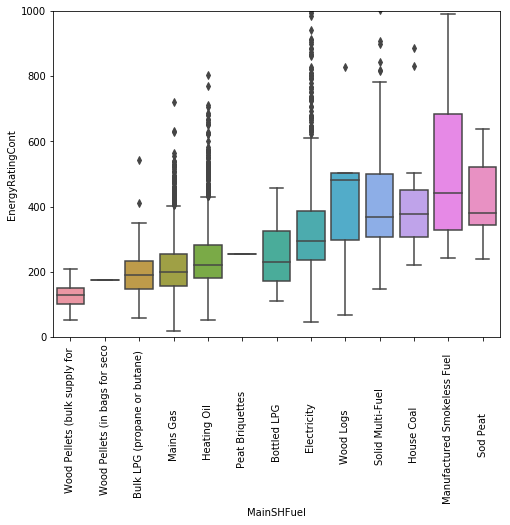

In [134]:
var = 'MainSHFuel'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat, order=correct_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

In [135]:
# And once again, lets order by the variable mean
correct_sort = training_cat.groupby(['MainWHFuel']).mean().to_dict()['EnergyRatingCont']
correct_sort = sorted(correct_sort, key=correct_sort.get)

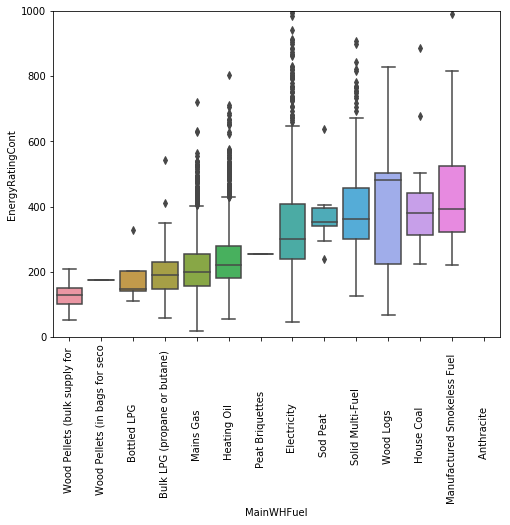

In [136]:
var = 'MainWHFuel'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat, order=correct_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

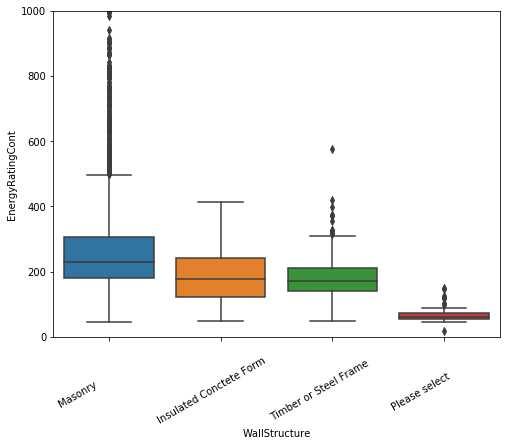

In [137]:
var = 'WallStructure'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_cat)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.axis(ymin=0, ymax=1000);

This plot proves very useful as we see an x value of 'Please select', which is clearly an error. Lets look at how many of these values are in the data set.

In [138]:
wall_str_errors = training_cat['WallStructure'].value_counts().reset_index()
wall_str_errors['percentage'] = wall_str_errors['WallStructure'].apply(lambda x: (x/4999)*100)
wall_str_errors

,index,WallStructure,percentage
0,Masonry,4556,91.138228
1,Timber or Steel Frame,325,6.501300
2,Please select,68,1.360272
3,Insulated Conctete Form,50,1.000200


Ok so a very small percentage of these values are tagged as 'Please select'; roughlu 1.36%. These will be replaced with an approprite value prior to model creation.

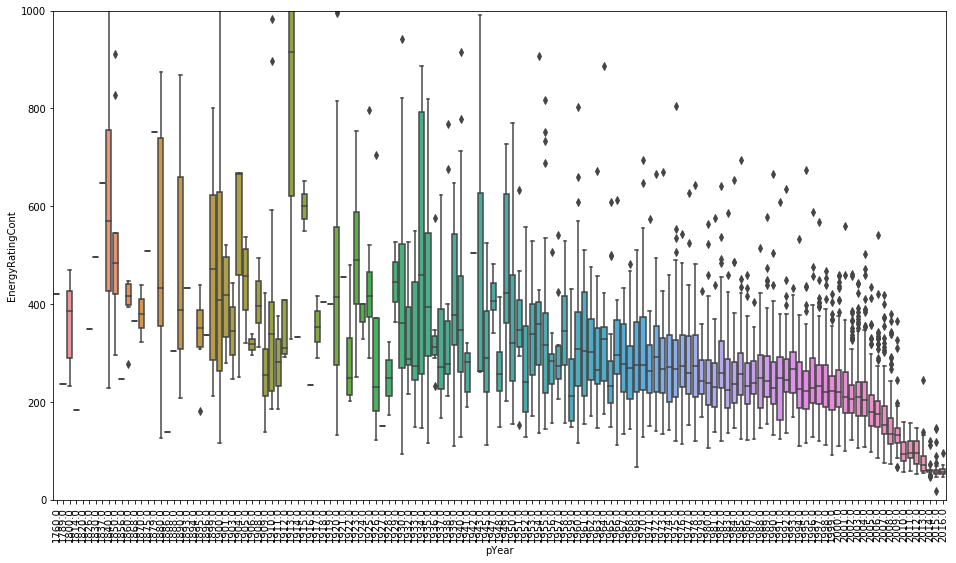

In [139]:
var = 'pYear'
f, ax = plt.subplots(figsize=(16, 9))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=training_num)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

A quick note on this graph. As expected, there seems to be a trend that as a home becomes newer, the better the property value becomes. The newer the house is also generally means the lower the variance.

## Section 2 - Deeper Exploration

The above exercise proved very useful. The analysis highlighted some very important insights into the variables I believed to be most important. 

But what about the variables I didn't think were as important, what if secretly, they're the lynch pin to this whole thing. Lets use a few different techniques to see if we can uncover any of these hidden important variables.

First, to bring as much data into focus as possible, lets do some light processing.

In [140]:
df.head(3)

,County,Type,Year,RatingType,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,...,EffSecondHeatGenPlant,PercSecondHeat,FuelTypeThirdBoiler,EffThirdHeatGenPlant,PercThirdHeat,HeatingSystemSolarSpace,TotPrimaryEnergyFac,TotCO2Emissions,PrimaryEnergySecondarySpace,EnergyMainWater
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,Co. Wexford,Mid-terrace house,Y1890.0,Existing,F,418.42,52.04 sq. m,2.10,2.30,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,2335.6809
523113,Co. Clare,Detached house,Y1901.0,Existing,G,520.35,147.44 sq. m,2.01,0.75,0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7144.838,4470.0759
271393,Co. Kerry,Detached house,Y1968.0,Existing,D2,281.33,104.84 sq. m,0.38,0.13,0.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2127.347,5837.4729


In [141]:
df.shape

(4999, 140)

#### Removing columns with high percentage of null values

In [142]:
null_df = df.isnull().sum()
null_df[null_df > 0].count()

68

68 of the 140 variables in the whole dataframe have null values. This is useful information. But is missing one or two values really that detrimental to our overall analysis? Probably not. Lets look at the overall percentage of missing values in each column and remove any columns missing over 15% of there total values.

In [143]:
null_df = null_df.reset_index()
null_df.columns = ['index', 'count']
null_df['percentage'] = null_df['count'].apply(lambda x: (x/4999)*100)
null_df.set_index('index', inplace=True)
null_df_15 = null_df[null_df['percentage'] > 15]

In [144]:
null_df_15

,count,percentage
index,,
AreaAperture,4730,94.618924
ZeroLossCollEff,4730,94.618924
CollHeatLoss,4730,94.618924
SolarRadiation,4730,94.618924
Overshading,4730,94.618924
DedicatedSolarVol,4730,94.618924
SolarPumpElect,4730,94.618924
SolarHeatFrac,4937,98.759752
LargestRoofType,2397,47.949590


In [145]:
len(null_df_15.index)

27

In [146]:
null_df_15.index

Index(['AreaAperture', 'ZeroLossCollEff', 'CollHeatLoss', 'SolarRadiation',
       'Overshading', 'DedicatedSolarVol', 'SolarPumpElect', 'SolarHeatFrac',
       'LargestRoofType', 'ProdFirstEnerComment', 'ConsFirstEnerComment',
       'ProdSecondEnerComment', 'ConsSecondEnerComment',
       'ProdThirdEnerComment', 'ConsThirdEnerComment', 'FuelTypeFirstBoiler',
       'EffFirstHeatGenPlant', 'PercFirstHeat', 'FuelTypeSecondBoiler',
       'EffSecondHeatGenPlant', 'PercSecondHeat', 'FuelTypeThirdBoiler',
       'EffThirdHeatGenPlant', 'PercThirdHeat', 'HeatingSystemSolarSpace',
       'TotPrimaryEnergyFac', 'TotCO2Emissions'],
      dtype='object', name='index')

So 27 of the 140 variables have over 15% of their values missing, and most of these were missing above 90%. Taking a quick look at the column names, none look considerably important, so lets drop them.

In [147]:
df = df.drop(null_df_15.index, axis='columns')
df.shape

(4999, 113)

With these removed, lets look at whats left.

In [148]:
g = df.columns.to_series().groupby(df.dtypes).groups
g

{dtype('float64'): Index(['EnergyRatingCont', 'AvgWallU', 'AvgRoofU', 'AvgFloorU', 'AvgWindowU',
        'AvgDoorU', 'ExposedWallArea', 'ExposedRoofArea', 'TotFloorArea',
        'TotWindowArea', 'TotDoorArea', 'NStoreys', 'MainSHEfficiency',
        'BuildingReg', 'MainSHAdj', 'SecSHFrac', 'SecSHEfficiency',
        'MainWHEfficiency', 'MainWHAdj', 'SecSHFuel', 'SecWHFuel', 'NChimneys',
        'NOpenFlues', 'NFansVents', 'PercDraughtStripped', 'NShelteredSides',
        'PermTestResult', 'TempAdj', 'ControlCat', 'ResponseCat', 'NCHPumps',
        'NGasFans', 'DistLoss', 'VolWaterStorage', 'TempFac', 'TempFacMult',
        'HWInsulationThickness', 'LightingEnergy', 'PumpsAndFansEnergy',
        'MainWaterEnergy', 'PrimaryLightingEnergy', 'PrimaryPumpsFansEnergy',
        'PrimaryMainWaterEnergy', 'PrimaryMainSpaceEnergy', 'LightingCO2',
        'PumpsAndFansCO2', 'MainWaterCO2', 'MainSpaceCO2', 'AreaGroundFloor',
        'HeightGroundFloor', 'AreaFirstFloor', 'HeightFirstFloor',
     

In [149]:
dtype_dict = {k.name: v for k, v in g.items()}
dtype_dict.keys()

dict_keys(['float64', 'object'])

In [150]:
print('Number of numerical columns: ', len(dtype_dict['float64']))
print('Number of object columns: ', len(dtype_dict['object']))

Number of numerical columns:  74
Number of object columns:  39


Great, 74 of the 113 columns are already numerical based. We can leave these alone for now. Lets dig into the object variables and see if a little processing can transform to the required numerical data

In [151]:
df[dtype_dict['object']].head()

,County,Type,Year,RatingType,EnergyRatingCat,GroundFloorArea,MainSHFuel,MainWHFuel,SharedMPRN,DLobby,...,SolarPumpPower,Charging,MainSpaceEnergy,MassCat,PercLivingArea,RatingPurpose,AssessmentDate,FirstEnerTypeDescr,SecondEnerTypeDescr,ThirdEnerTypeDescr
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,Co. Wexford,Mid-terrace house,Y1890.0,Existing,F,52.04 sq. m,Heating Oil,Heating Oil,NO,NO,...,NO,NO,13700.589,Medium,33.4935%,Unknown,Jun 17 2011 12:00AM,Renewable Thermal,Renewable Thermal,Renewable Thermal
523113,Co. Clare,Detached house,Y1901.0,Existing,G,147.44 sq. m,Heating Oil,Heating Oil,NO,NO,...,NO,NO,"""52025.518""",Medium-high,11.0079%,Sale,Apr 14 2015 12:00AM,Renewable Thermal,Renewable Thermal,Renewable Thermal
271393,Co. Kerry,Detached house,Y1968.0,Existing,D2,104.84 sq. m,Heating Oil,Heating Oil,NO,NO,...,NO,NO,15704.271999999999,High,18.0465%,Grant Support,Jun 28 2012 12:00AM,Renewable Thermal,Renewable Thermal,Renewable Thermal
585961,Co. Cork,Semi-detached house,Y2002.0,Existing,C2,95.31 sq. m,Mains Gas,Mains Gas,NO,NO,...,NO,NO,7995.825,Medium,18.1513%,Grant Support,Nov 25 2015 12:00AM,Renewable Thermal,Renewable Thermal,Renewable Thermal
624083,Co. Laois,Detached house,Y2002.0,Existing,B3,283.87 sq. m,Mains Gas,Mains Gas,NO,NO,...,NO,NO,24401.932,Medium-high,12.1887%,Sale,May 30 2016 12:00AM,Renewable Thermal,Renewable Thermal,Renewable Thermal


Ok this processing might take some time, but it'll be worth it for our deeper analysis.

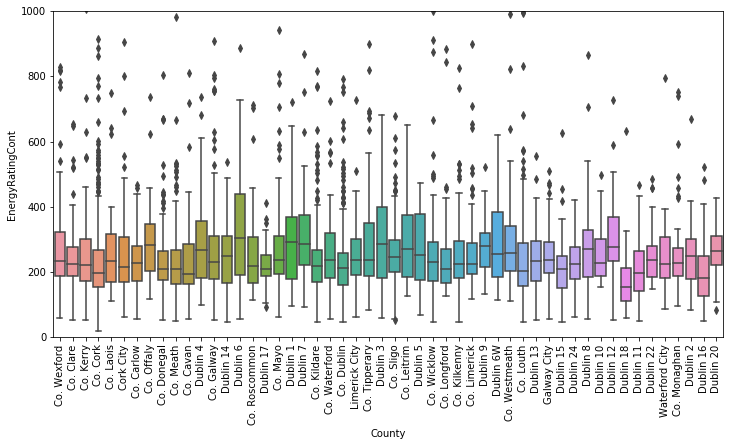

In [152]:
# County
var = 'County'
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=df)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

This graph shows very little evidence that county will have any significant bearing on predicting energy ratings, so lets drop it.

In [153]:
df.drop('County', axis='columns', inplace=True)

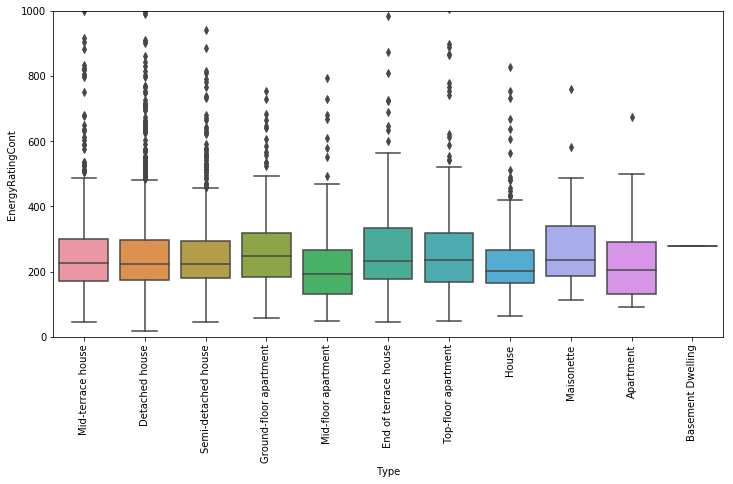

In [154]:
# Type
var = 'Type'
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=df)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

Again, this seems like it has very little predictive value, however I thought it would :/ As I dropped county, I feel I'm also obliged to drop type.

In [155]:
df.drop('Type', axis='columns', inplace=True)

In [156]:
# Year 

As we saw in our earlier analysis, Year does seem to have some predictive value, so lets remove the Y in front of each year and keep it in the dataframe.

In [157]:
df['Year'] = df['Year'].map(lambda x: x[1:])

In [158]:
# RatingType
df['RatingType'].unique()

array(['Existing       ', 'Final          ', 'Provisional    '], dtype=object)

In [159]:
df['RatingType'].value_counts()

Existing           4596
Final               335
Provisional          68
Name: RatingType, dtype: int64

Straight away looking at these numbers this doesn't look like it'll have any predive power. Lets graph it just to be sure.

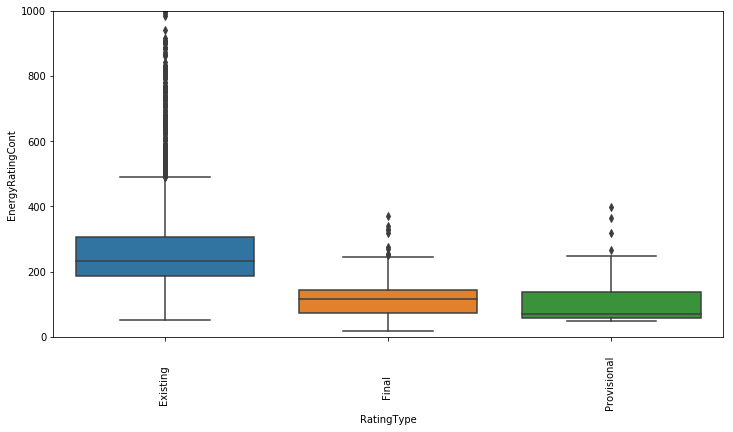

In [160]:
var = 'RatingType'
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=df)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=1000);

The low amount of values in Final and Provisional makes me believe these numbers could be easily skewed. I think dropping these makes sense.

In [161]:
df.drop('RatingType', axis='columns', inplace=True)

#### GroundFloorArea
Similar to Year, our analysis earlier shows that this has some useful predictive value. Lets process it and keep it.

In [162]:
df['GroundFloorArea'] = df['GroundFloorArea'].apply(lambda x: float(x[:-5]))

#### MainSHFuel

In [163]:
df['MainSHFuel'].unique()

array(['Heating Oil                   ', 'Mains Gas                     ',
       'Solid Multi-Fuel              ', 'Electricity                   ',
       'Bulk LPG (propane or butane)  ', 'Bottled LPG                   ',
       'Sod Peat                      ', 'Wood Pellets (bulk supply for ',
       'Manufactured Smokeless Fuel   ', nan,
       'House Coal                    ', 'Wood Logs                     ',
       'Wood Pellets (in bags for seco', 'Peat Briquettes               '], dtype=object)

In [164]:
df['MainSHFuel'].value_counts()

Mains Gas                         1969
Heating Oil                       1899
Electricity                        678
Solid Multi-Fuel                   207
Bulk LPG (propane or butane)        89
Manufactured Smokeless Fuel         31
House Coal                          29
Sod Peat                            11
Wood Pellets (bulk supply for       10
Bottled LPG                          7
Wood Logs                            5
Wood Pellets (in bags for seco       1
Peat Briquettes                      1
Name: MainSHFuel, dtype: int64

In [184]:
MainSHFuel_sort = df.groupby(['MainSHFuel']).mean().to_dict()['EnergyRatingCont']
MainSHFuel_sort = sorted(MainSHFuel_sort, key=MainSHFuel_sort.get)

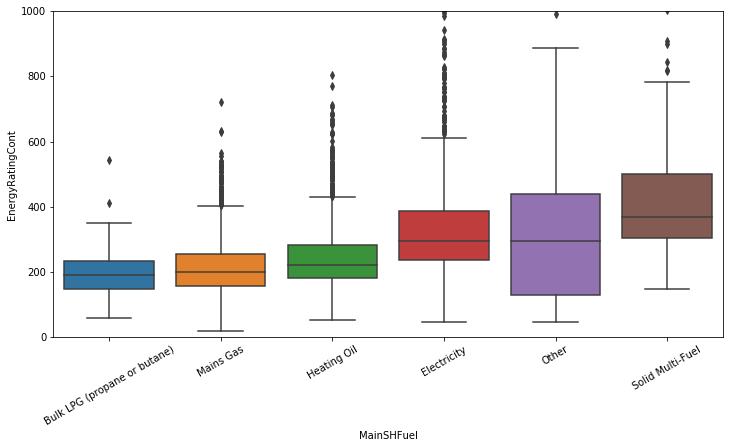

In [185]:
var = 'MainSHFuel'
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=df, order=MainSHFuel_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.axis(ymin=0, ymax=1000);

This looks useful. Some fuel sources definitely seem to have a negative impact on the overall rating. A number of the option however appear pretty irregulary. To reduce the size of the list, I'm going to group these into one 'Other' column.

In [167]:
replace_list = ['Manufactured Smokeless Fuel   ', 'House Coal                    ', 'Sod Peat                      ', 
                'Wood Pellets (bulk supply for ', 'Bottled LPG                   ',
                'Wood Logs                     ', 'Wood Pellets (in bags for seco', 'Peat Briquettes               ']   

df['MainSHFuel'].replace(replace_list, 'Other', inplace=True)

In [168]:
df['MainSHFuel'].value_counts()

Mains Gas                         1969
Heating Oil                       1899
Electricity                        678
Solid Multi-Fuel                   207
Other                               95
Bulk LPG (propane or butane)        89
Name: MainSHFuel, dtype: int64

In [169]:
# The above shows theres a lot of white space around the values. Lets remove these.
df['MainSHFuel'].fillna('Other', inplace=True)
df['MainSHFuel'] = df['MainSHFuel'].apply(lambda x: x.strip())
df['MainSHFuel'].unique()

array(['Heating Oil', 'Mains Gas', 'Solid Multi-Fuel', 'Electricity',
       'Bulk LPG (propane or butane)', 'Other'], dtype=object)

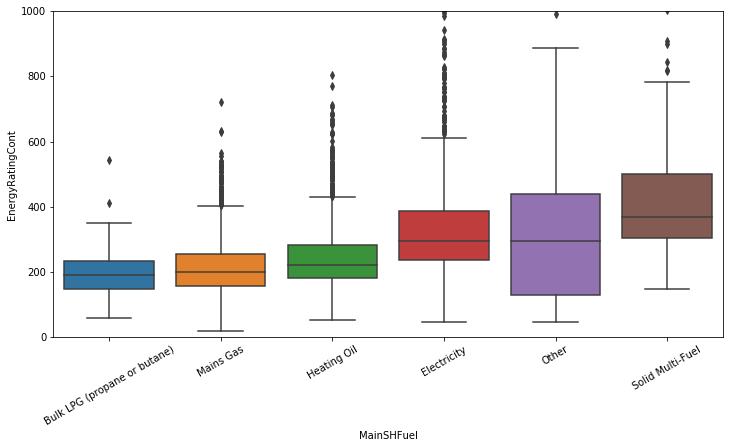

In [170]:
new_MainSHFuel_sort = df.groupby(['MainSHFuel']).mean().to_dict()['EnergyRatingCont']
new_MainSHFuel_sort = sorted(new_MainSHFuel_sort, key=new_MainSHFuel_sort.get)

var = 'MainSHFuel'
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=df, order=new_MainSHFuel_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.axis(ymin=0, ymax=1000);

Ok this looks, and feels, a lot better. And finally, lets change this from categorical to numerical.

In [171]:
df['MainSHFuel_cat'] = df['MainSHFuel'].astype('category').cat.codes

In [172]:
df.loc[:,['MainSHFuel', 'MainSHFuel_cat']].head()

,MainSHFuel,MainSHFuel_cat
BuildingID,,
190835,Heating Oil,2
523113,Heating Oil,2
271393,Heating Oil,2
585961,Mains Gas,3
624083,Mains Gas,3


#### MainWHFuel

In [176]:
df['MainWHFuel'].fillna('Other', inplace=True)
df['MainWHFuel'] = df['MainWHFuel'].apply(lambda x: x.strip())
df['MainWHFuel'].unique()

array(['Heating Oil', 'Mains Gas', 'Solid Multi-Fuel', 'Electricity',
       'Bulk LPG (propane or butane)', 'Bottled LPG',
       'Wood Pellets (bulk supply for', 'Wood Logs',
       'Manufactured Smokeless Fuel', 'Other', 'House Coal', 'Sod Peat',
       'Wood Pellets (in bags for seco', 'Anthracite', 'Peat Briquettes'], dtype=object)

In [177]:
df['MainWHFuel'].value_counts()

Mains Gas                         1956
Heating Oil                       1886
Electricity                        729
Solid Multi-Fuel                   194
Bulk LPG (propane or butane)        89
Other                               62
House Coal                          26
Manufactured Smokeless Fuel         25
Wood Pellets (bulk supply for       10
Sod Peat                             9
Bottled LPG                          5
Wood Logs                            5
Wood Pellets (in bags for seco       1
Anthracite                           1
Peat Briquettes                      1
Name: MainWHFuel, dtype: int64

In [178]:
rollup_list = ['Wood Pellets (in bags for seco', 'Anthracite', 'Peat Briquettes',
              'Wood Pellets (bulk supply for', 'Wood Logs', 'Bottled LPG',
              'Sod Peat']

df['MainWHFuel'].replace(rollup_list, 'Other', inplace=True)
df['MainWHFuel'].value_counts()

Mains Gas                       1956
Heating Oil                     1886
Electricity                      729
Solid Multi-Fuel                 194
Other                             94
Bulk LPG (propane or butane)      89
House Coal                        26
Manufactured Smokeless Fuel       25
Name: MainWHFuel, dtype: int64

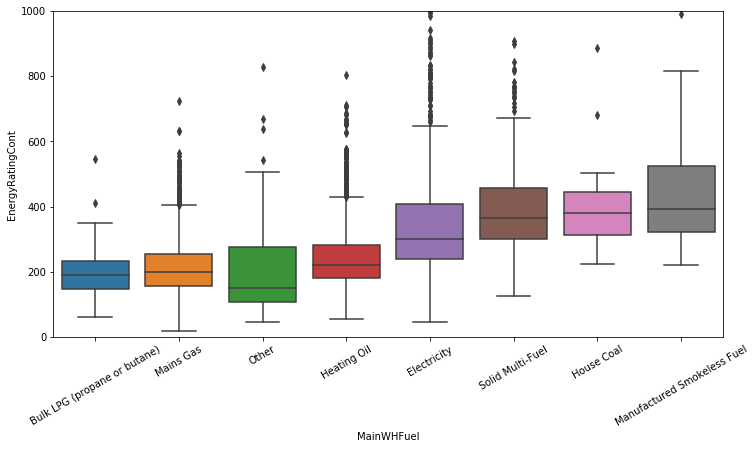

In [179]:
new_MainWHFuel_sort = df.groupby(['MainWHFuel']).mean().to_dict()['EnergyRatingCont']
new_MainWHFuel_sort = sorted(new_MainWHFuel_sort, key=new_MainWHFuel_sort.get)

var = 'MainWHFuel'
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="EnergyRatingCont", data=df, order=new_MainWHFuel_sort)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.axis(ymin=0, ymax=1000);

Ok all this looks good. Again, lets transform the categories to numerical values.

In [181]:
df['MainWHFuel_cat'] = df['MainWHFuel'].astype('category').cat.codes

In [182]:
df.loc[:,['MainWHFuel', 'MainWHFuel_cat']].head()

,MainWHFuel,MainWHFuel_cat
BuildingID,,
190835,Heating Oil,2
523113,Heating Oil,2
271393,Heating Oil,2
585961,Mains Gas,4
624083,Mains Gas,4


#### SharedMPRN

In [186]:
df['SharedMPRN'].unique()
# binary variable

array(['NO', 'YES'], dtype=object)

In [187]:
df['SharedMPRN'].isnull().sum()
# no null values

0

In [188]:
df['SharedMPRN'].value_counts()

NO     4970
YES      29
Name: SharedMPRN, dtype: int64

The value counts shows how very lopsided this variable is. I don't feel this will have much, if any predictive power so I'm going to drop it.

In [189]:
df.drop('SharedMPRN', axis='columns', inplace=True)

#### DLobby

In [190]:
df['DLobby'].unique()
# binary variable

array(['NO', 'YES'], dtype=object)

In [191]:
df['DLobby'].value_counts()

NO     4019
YES     980
Name: DLobby, dtype: int64

Again, this is pretty lobsided, so we'll drop it.

In [192]:
df.drop('DLobby', axis='columns', inplace=True)

The remaining categorical variables, listed below, require further analysis but as they all don't stand as as particularly valuable, I'll leave this task for now and focus on what we already have available to us.

In [199]:
# TODO: 
other_cat_variables = ['VentMethod', 'WallStructure', 'SuspWoodFloor', 'PermTest',
'BoilerStat1', 'BoilerStat2', 'OilPumpIn', 'WarmAir', 'Underfloor',
'StorageLoss', 'DeclaredLoss', 'SolarWaterHeating', 'SummerElectricImm',
'Combi', 'KeepHot', 'HWInsulationType', 'PrimaryLoss',
'CylinderThermostat', 'CombiCylinder', 'SolarPumpPower', 'Charging',
'MainSpaceEnergy', 'MassCat', 'PercLivingArea', 'RatingPurpose',
'AssessmentDate', 'FirstEnerTypeDescr', 'SecondEnerTypeDescr',
'ThirdEnerTypeDescr']

To finish up, lets drop the above variables from the data frame.

In [200]:
df.drop(other_cat_variables, axis='columns', inplace=True)

In [201]:
df.head()

,Year,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,AvgWindowU,AvgDoorU,ExposedWallArea,...,ProdFirstEnerDelivered,ProdFirstEnerConvFac,ProdSecondEnerDelivered,ProdSecondEnerConvFac,ProdThirdEnerDelivered,ProdThirdEnerConvFac,PrimaryEnergySecondarySpace,EnergyMainWater,MainSHFuel_cat,MainWHFuel_cat
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,1890.0,F,418.42,52.04,2.10,2.30,0.61,2.71,3.00,32.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,2335.6809,2,2
523113,1901.0,G,520.35,147.44,2.01,0.75,0.94,2.63,3.96,211.22,...,0.0,0.0,0.0,0.0,0.0,0.0,7144.838,4470.0759,2,2
271393,1968.0,D2,281.33,104.84,0.38,0.13,0.68,2.81,0.00,94.41,...,0.0,0.0,0.0,0.0,0.0,0.0,2127.347,5837.4729,2,2
585961,2002.0,C2,188.17,95.31,0.55,0.26,0.34,2.80,3.03,89.50,...,0.0,0.0,0.0,0.0,0.0,0.0,2771.886,3769.6248,3,4
624083,2002.0,B3,134.95,283.87,0.55,0.26,0.41,3.10,3.01,254.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,5296.5828,3,4


In [203]:
df.shape

(4999, 81)

### Correlation Matrix

##### Why are correlation matrices useful you ask?

The correlation is a number between -1 and +1 that measures how close the relationship between two variables is to being linear (i.e., forming a straight line if the two were graphed against each other). Correlation = +1 means variables are perfectly positively correlated (they go up and down in perfect synchronization; e.g., dollars of sales and sales tax); -1 means perfect negative correlation (one goes up and the other goes down; e.g., items sold and inventory); values close to 0 mean either no relation or the relation isn't linear (e.g., annual rainfall and average shoe size). Correlation is independent of scale; measuring one variable in millions and the other in millionths won't affect it.

In [204]:
df.shape

(4999, 81)

In [205]:
null_df = df.isnull().sum()
null_df.head()

Year                  0
EnergyRatingCat       0
EnergyRatingCont      0
GroundFloorArea     502
AvgWallU            486
dtype: int64

In [207]:
null_df_to_drop = null_df[null_df>4000].index.tolist()
null_df_to_drop

[]

In [208]:
df = df.drop(null_df_to_drop, axis='columns')
df.shape

(4999, 81)

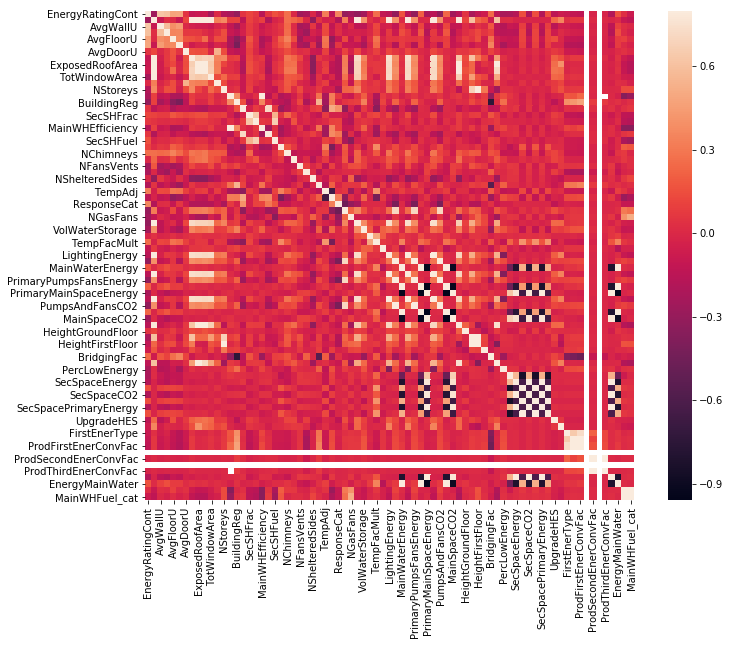

In [209]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [210]:
df.head()

,Year,EnergyRatingCat,EnergyRatingCont,GroundFloorArea,AvgWallU,AvgRoofU,AvgFloorU,AvgWindowU,AvgDoorU,ExposedWallArea,...,ProdFirstEnerDelivered,ProdFirstEnerConvFac,ProdSecondEnerDelivered,ProdSecondEnerConvFac,ProdThirdEnerDelivered,ProdThirdEnerConvFac,PrimaryEnergySecondarySpace,EnergyMainWater,MainSHFuel_cat,MainWHFuel_cat
BuildingID,,,,,,,,,,,,,,,,,,,,,
190835,1890.0,F,418.42,52.04,2.10,2.30,0.61,2.71,3.00,32.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,2335.6809,2,2
523113,1901.0,G,520.35,147.44,2.01,0.75,0.94,2.63,3.96,211.22,...,0.0,0.0,0.0,0.0,0.0,0.0,7144.838,4470.0759,2,2
271393,1968.0,D2,281.33,104.84,0.38,0.13,0.68,2.81,0.00,94.41,...,0.0,0.0,0.0,0.0,0.0,0.0,2127.347,5837.4729,2,2
585961,2002.0,C2,188.17,95.31,0.55,0.26,0.34,2.80,3.03,89.50,...,0.0,0.0,0.0,0.0,0.0,0.0,2771.886,3769.6248,3,4
624083,2002.0,B3,134.95,283.87,0.55,0.26,0.41,3.10,3.01,254.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,5296.5828,3,4


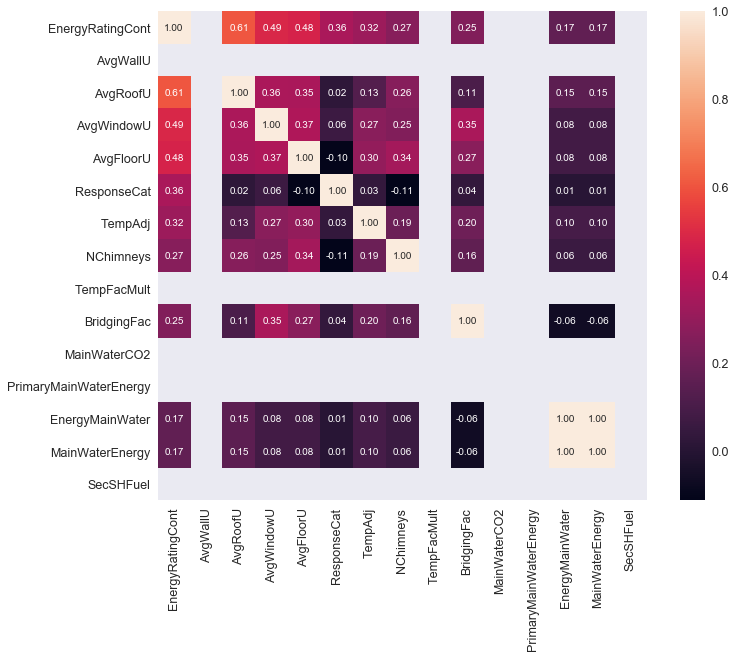

In [212]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'EnergyRatingCont')['EnergyRatingCont'].index
cm = np.corrcoef(training[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()